In [197]:
import pandas as pd


def extract_best_per_run(lst, epoch=3):
    """
    Extracts the best (maximum) value from each run of n epochs.

    Args:
    lst (list): A list of values.
    epoch (int): The number of epochs in each run. Default is 3.

    Returns:
    list: A list of the best (maximum) value from each run.
    """

    # Split the list into sub-lists of `epoch` elements each
    runs = [lst[i : i + epoch] for i in range(0, len(lst), epoch)]

    # Find the best (maximum) value in each run
    best_per_run = [max(run) for run in runs]

    return best_per_run


# read the buggy_cv.csv file
df = pd.read_csv("cv_results.csv")

# apply extract_best_per_run() function on each row of f1, recall and accuracy columns

import ast

# Apply the function to each metric column
for column in ["f1", "accuracy", "recall"]:
    df[column] = df[column].apply(
        ast.literal_eval
    )  # Convert string representation of list to actual list
    df[f"best_{column}"] = df[column].apply(lambda x: extract_best_per_run(x))


In [198]:
df.tail(1)["model_name"].tolist()[0]

'flaubert/flaubert_large_cased'

baseline is camembert/camembert-large


/Users/xiaoou/miniconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/xiaoou/miniconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


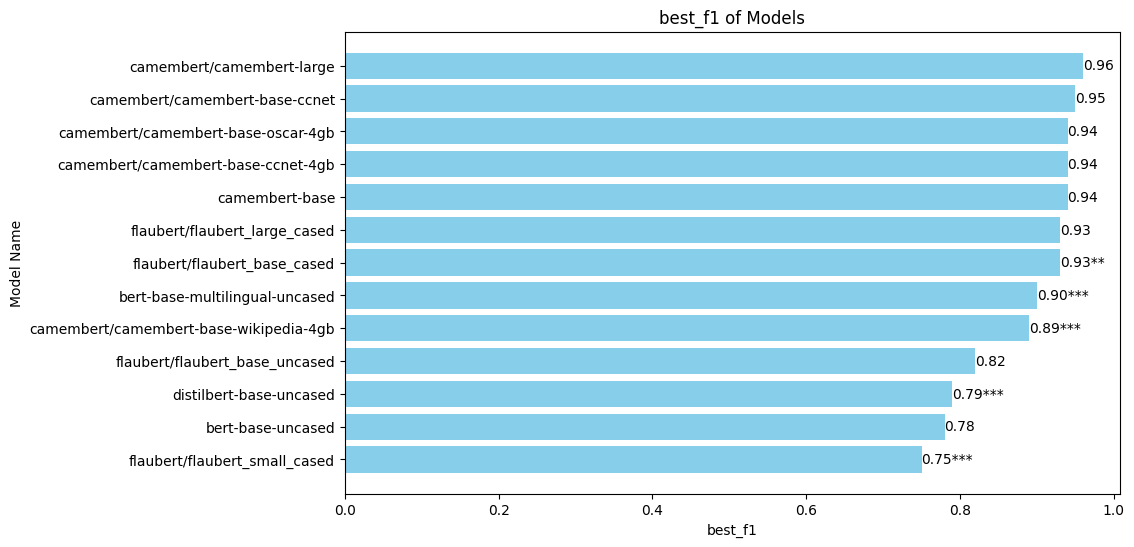

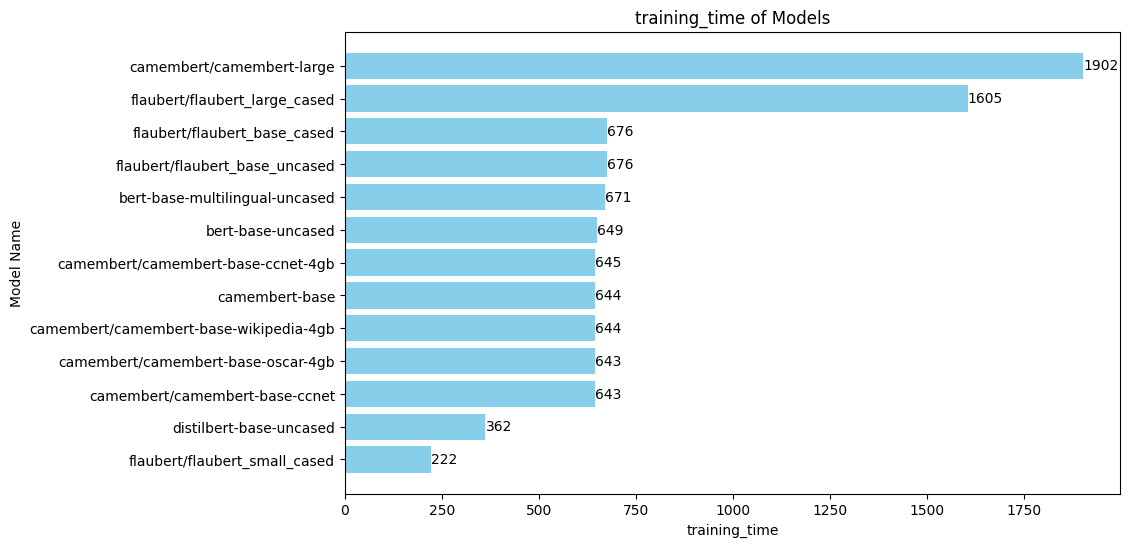

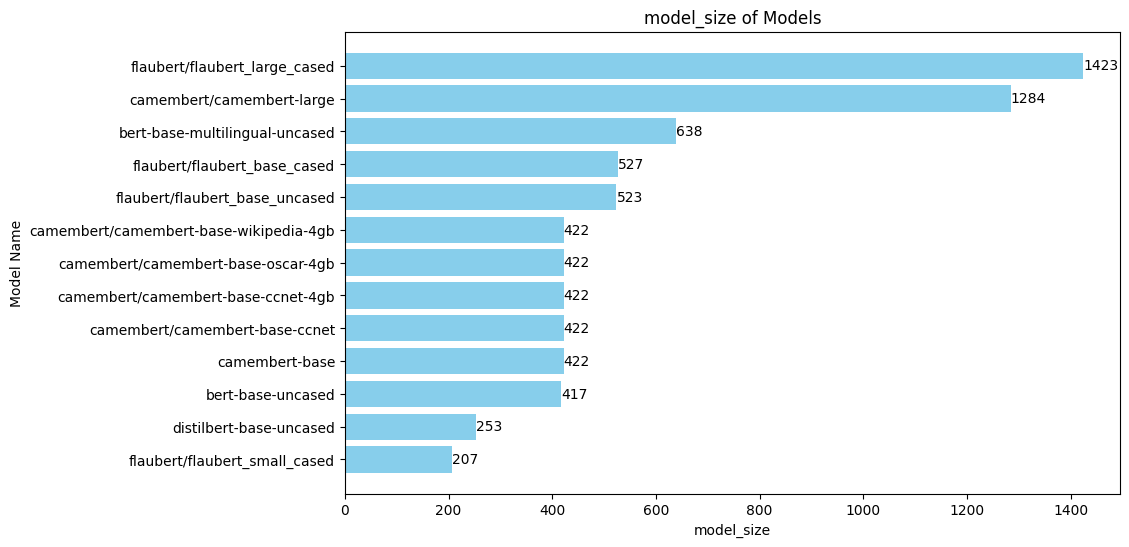

In [199]:
from scipy.stats import ttest_ind, wilcoxon, shapiro

def p_value_to_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

def perform_tests(list1, list2):
    shapiro_test_list1 = shapiro(list1)
    shapiro_test_list2 = shapiro(list2)

    if shapiro_test_list1[1] > 0.05 and shapiro_test_list2[1] > 0.05:
        # If both lists pass the Shapiro test (p > 0.05), perform t-test
        Test_name = 'T-test'
    else:
        # If either list fails the Shapiro test, perform Wilcoxon test
        # test_result = wilcoxon(list1, list2)
        Test_name = 'Wilcoxon'
    test_result_ttest = ttest_ind(list1, list2)
    test_result_wilcoxon = wilcoxon(list1, list2)
    mean1 = sum(list1)/len(list1)
    mean2 = sum(list1)/len(list1)

    return {"T-test": test_result_ttest[1], "Wilcoxon": test_result_wilcoxon[1], "Test_name": Test_name, "mean1": mean1, "mean2": mean2}

# df
df['mean_best_f1'] = df['best_f1'].apply(lambda x: round(sum(x)/len(x), 2))
df['mean_best_accuracy'] = df['best_accuracy'].apply(lambda x: round(sum(x)/len(x), 2))
df['mean_best_recall'] = df['best_recall'].apply(lambda x: round(sum(x)/len(x), 2))


#  Sorting the DataFrame by 'mean_best_f1' in descending order

import matplotlib.pyplot as plt

def plot_model_performance_scores(df, indep='model_name', dep='best_f1'):
    plt.figure(figsize=(10, 6))
    # Sorting the DataFrame by ascending order

    # calculate the mean for the dep and sort to show the bars
    df["mean"] = df[dep].apply(lambda x: round(sum(x)/len(x), 2))
    df = df.sort_values(by="mean", ascending=True)
    bars = plt.barh(df[indep], df["mean"], color='skyblue')

    # add the stars for the significance
    significance = []
    # the baseline is the last row since ascending is true
    baseline = df.tail(1)[dep].tolist()[0]
    baseline_name = df.tail(1)[indep].tolist()[0]
    print(f"baseline is {baseline_name}")
    for index, row in df.iterrows():
        if row['model_name'] != baseline_name:
            model_f1_scores = row['best_f1']
            p_values = perform_tests(baseline, model_f1_scores)
            stars = p_value_to_stars(p_values[p_values['Test_name']])
            significance.append(stars)

    # Plot bars, adding the value and significant diff at the end of each bar

    for i,bar in enumerate(bars):
        if i!= len(bars)-1:
            value = bar.get_width()
            # get the bar's name
            if value > 100:
                text = f'{int(value)}'  # No decimals for values over 100
            else:
                text = f'{value:.2f}'  # Two decimal places for other values
            if significance[i] != 'ns':
                plt.text(value, bar.get_y() + bar.get_height()/2, text + significance[i], va='center')
            else:
                plt.text(value, bar.get_y() + bar.get_height()/2, text, va='center')
        else:
            value = bar.get_width()
            # get the bar's name
            if value > 100:
                text = f'{int(value)}'
                plt.text(value, bar.get_y() + bar.get_height()/2, text, va='center')
            else:
                text = f'{value:.2f}'
                plt.text(value, bar.get_y() + bar.get_height()/2, text, va='center')

    # Adding labels and title
    plt.xlabel(dep)
    plt.ylabel('Model Name')
    plt.title(f'{dep} of Models')

    # Show the plot
    plt.show()

def plot_model_performance(df, indep='model_name', dep='mean_best_f1'):
    # Sorting the DataFrame by descending order
    df = df.sort_values(by=dep, ascending=True)

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df[indep], df[dep], color='skyblue')

    # Adding the value at the end of each bar
    for bar in bars:
        value = bar.get_width()
        # get the bar's name
        if value > 100:
            text = f'{int(value)}'  # No decimals for values over 100
        else:
            text = f'{value:.2f}'  # Two decimal places for other values
        plt.text(value, bar.get_y() + bar.get_height()/2, text, va='center')

    # Adding labels and title
    plt.xlabel(dep)
    plt.ylabel('Model Name')
    plt.title(f'{dep} of Models')

    # Show the plot
    plt.show()


# Call the function
plot_model_performance_scores(df, indep='model_name', dep='best_f1')
plot_model_performance(df, indep='model_name', dep='training_time')
plot_model_performance(df, indep='model_name', dep='model_size')


In [200]:
df[df['model_name'] == 'flaubert/flaubert_base_uncased']['best_f1']

10    [0.94, 0.94, 0.92, 0.37, 0.93]
Name: best_f1, dtype: object

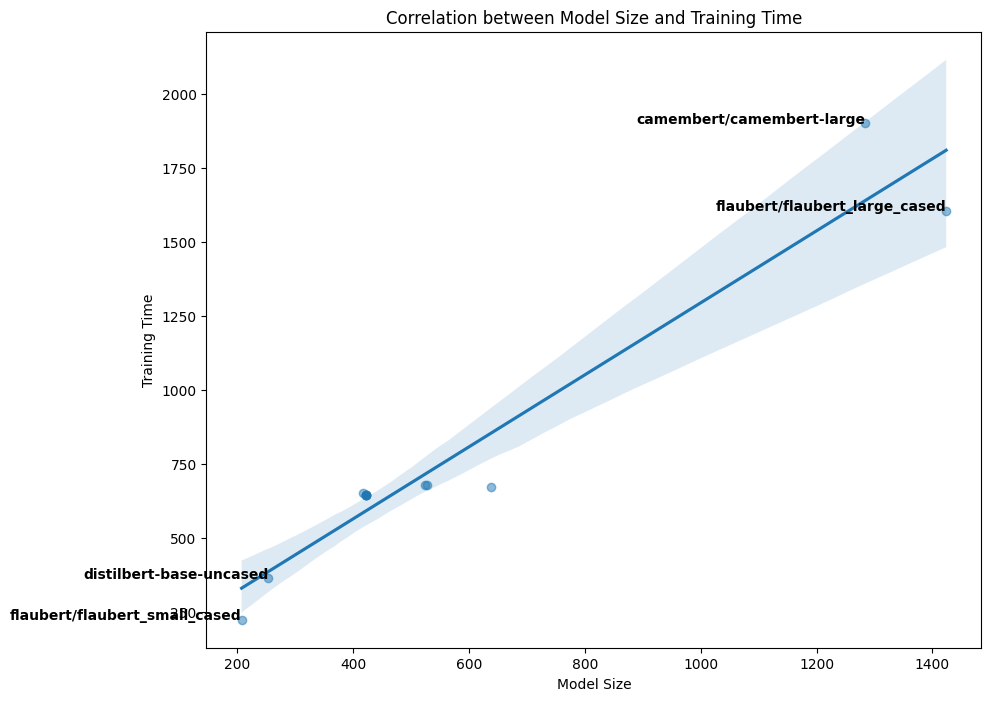

Correlation coefficient: 0.9648028378297552
P-value: 1.0081890339483466e-07


In [201]:
import pandas as pd
import numpy as np

# Correlation between model size and training time

import seaborn as sns
import scipy.stats as stats


# Scatter plot with a regression line
plt.figure(figsize=(10, 8))
sns.regplot(x='model_size', y='training_time', data=df, scatter_kws={'alpha':0.5})

# Label each point with model name
for i in range(len(df)):
    if df['training_time'][i] > 1200 or df['training_time'][i] < 500:
        plt.text(df['model_size'][i], df['training_time'][i], df['model_name'][i],
                 horizontalalignment='right', size='medium', color='black', weight='semibold')

plt.xlabel('Model Size')
plt.ylabel('Training Time')
plt.title('Correlation between Model Size and Training Time')

# Show the plot
plt.show()

# Calculating the correlation coefficient and the p-value
correlation, p_value = stats.pearsonr(df['model_size'], df['training_time'])
print(f'Correlation coefficient: {correlation}')
print(f'P-value: {p_value}')